# 直连MICAPS Cassandra 数据库读取数值模式、卫星雷达等数据

#### —— nmc_met_io程序库读取MICAPS分布式数据环境（BDIPS）使用说明

宜昌市气象局
longtsing 2022，songofsongs@vip.qq.com


MICAPS分布式数据环境（BDIPS）提供了两种访问方式:一种是直接连接读取Cassandra数据库，另外一种是基于Cassandra数据库上搭建的WEBService API方式检索读取。

[nmc_met_io](https://github.com/nmcdev/nmc_met_io)程序库的[retrieve_cassandraDB](https://github.com/nmcdev/nmc_met_io/blob/master/nmc_met_io/retrieve_micaps_server.py)模块, 基于Python Cassandra数据库接口包实现了Python语言对BDIPS数据的检索和读取。
（注：由于WEBService的使用泛滥，各省已经限制该接口只能下载三天内的数据，为此启用Cassandra读取方式能延长读取数据的时效；但各省在Cassandra数据库存储数据时长也有不同，一般存储一周以上的数据。）

### retrieve_cassandra模块主要功能:
* 使用Cassandra的python接口, 读取程序库;
* 接口定义与retrieve_micaps_server一致；
* 引入的本地文件缓存技术, 加快数据的快速读取;
* 支持模式数据标量场, 矢量场及集合成员数据的读取; 
* 支持模式单点时间序列, 单点廓线及廓线时序的读取;
* 支持站点, 探空观测数据的读取;
* 支持awx格式的静止气象卫星等经纬度数据读取;
* 支持LATLON格式的雷达拼图数据读取;
* 统一的返回数据类型, 格点数据返回为[xarray](http://xarray.pydata.org/en/stable/)类型, 站点数据返回为[pandas.DataFrame](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.html)类型.

### 参考网站
* https://github.com/nmcdev/nmc_met_io
* https://github.com/datastax/python-driver
* https://docs.datastax.com/en/developer/python-driver/3.25/getting_started/
---

## 1. 安装和配置nmc_met_io程序库

* 建议安装[Anaconda](https://www.anaconda.com/distribution/)的Python环境.
* [nmc_met_io](https://github.com/nmcdev/nmc_met_io)有详细安装说明.
* 需要配置Cassandra集群访问接口，具体在C:\Users\用户名\.nmcdev 目录下的config.ini内配置
```
[Cassandra]
ClusterIPAddresses=Cassandra集群IP地址以“,”分隔，可以参考MICAPS4的配置文件配置
ClusterPort=Cassandra集群服务端口
KeySpace=Cassandra上数据存储的主键名
```


In [1]:
# set up things
%matplotlib inline
%load_ext autoreload
%autoreload 2

D:\ProgramData\Anaconda3\envs\gpu1\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
D:\ProgramData\Anaconda3\envs\gpu1\lib\site-packages\numpy\.libs\libopenblas.EL2C6PLE4ZYW3ECEVIV3OXXGRN2NRFM2.gfortran-win_amd64.dll
D:\ProgramData\Anaconda3\envs\gpu1\lib\site-packages\numpy\.libs\libopenblas.GK7GX5KEQ4F6UYO3P26ULGBQYHGQO7J4.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


In [2]:
# load necessary libraries
# you should install cartopy with 'conda install -c conda-forge cartopy'
import xarray as xr
import numpy as np

# load nmc_met_io for retrieving micaps server data
import sys
sys.path.append("../nmc_met_io")
from retrieve_cassandraDB import *

xr.set_options(display_style="text")

## 2. 读取数值模式预报数据

模块`retrieve_cassandraDB`提供读取数值模式网格预报数据的函数:
 * `get_model_grid`: 读取单个时次标量, 矢量或集合成员的2D平面预报数据;
 * `get_model_grids`: 读取多个时次标量, 矢量或集合成员的2D平面预报数据;
 * `get_model_points`: 获取指定经纬度点的模式预报数据;
 * `get_model_3D_grid`: 获得单个时次标量, 矢量或集合成员的[lev, lat, lon]3D预报数据;
 * `get_model_3D_grids`: 获得多个时次标量, 矢量或集合成员的[lev, lat, lon]3D预报数据;
 * `get_model_profiles`: 获得制定经纬度单点的模块廓线预报数据.

每个函数都有固定的参数`directory`和`filename`(或`filenames`), 例如
```Python
# MICAPS分布式服务器上的数据地址, 可通过MICAPS4的数据源检索界面查找,
# 如下图, 找到数据存放的目录, 鼠标右键点击"保存路径到剪切板", 粘贴去掉"mdfs:///"
directory = 'ECMWF_HR/TMP/850'
# 指定具体的数据文件, 一般格式为"起报时间.预报时效", 若不指定, 则自动获得目录下最新数据的文件名
filename = '22022408.024'
# 调用函数读取数据
data = get_model_grid(directory, filename=filename)
```

<img src="./images/micaps_retrieve_UI.png" alt="image" style="height: 400px;">

### 2.1 读取单个时次模式标量预报数据

In [3]:
directory = 'ECMWF_HR/TMP/850'
filename = '22022408.024'
data = get_model_grid(directory, filename=filename, cache=False)
if data is not None:
    print(data)
else:
    print("Retrieve failed.")

<xarray.Dataset>
Dimensions:                  (time: 1, level: 1, lat: 241, lon: 361)
Coordinates:
  * time                     (time) datetime64[ns] 2022-02-25T08:00:00
  * level                    (level) float32 850.0
  * lat                      (lat) float64 3.815e-06 0.25 0.5 ... 59.75 60.0
  * lon                      (lon) float64 60.0 60.25 60.5 ... 149.5 149.8 150.0
    forecast_reference_time  datetime64[ns] 2022-02-24T08:00:00
    forecast_period          (time) float64 24.0
Data variables:
    data                     (time, level, lat, lon) float32 19.45 ... -14.65
Attributes:
    Conventions:  CF-1.6
    Origin:       MICAPS Cassandra DB


<div class="alert alert-success">
    <b>返回xarray数据结构</b>:
    <ul>
        <li>返回的数据类型为[xarray](http://xarray.pydata.org/en/stable/)的Dataset结构数据(如下图所示).</li>
        <li>xarray为在numpy数组基础上增加维度, 坐标和属性信息, 其数据模型来自于netCDF文件结构.</li>
        <li>xarray提供直观,简介且可靠的格点数据操作功能, 已成为地球环境科学的标准数据处理程序库, 与很多现有的开源软件兼容.</li>
        <li><em>get_model_grid</em>根据读取数据类型返回不同维度的Dataset数据. 如上对于高空数据, 返回数据的维度分别为(time, level, lat, lon).</li>
        <li>在坐标Coordinate信息中, 除了数组维度的信息, 还给出起报时间forecast_reference_time和预报时效forecast_period</li>
    </ul>
</div>

<img src="./images/xarray_dataset.png" width="600">

In [4]:
# 使用?可以获得函数的帮助信息.
?get_model_grid

Signature:
get_model_grid(
    directory,
    filename=None,
    suffix='*.024',
    varname='data',
    varattrs={'units': ''},
    scale_off=None,
    levattrs={'long_name': 'pressure_level', 'units': 'hPa', '_CoordinateAxisType': 'Pressure'},
    cache=True,
    cache_clear=True,
)
Docstring:
Retrieve numeric model grid forecast from MICAPS cassandra service.
Support ensemble member forecast.

:param directory: the data directory on the service
:param filename: the data filename, if none, will be the latest file.
:param suffix: the filename filter pattern which will be used to
               find the specified file.
:param varname: set variable name.
:param varattrs: set variable attributes, dictionary type.
:param scale_off: [scale, offset], return values = values*scale + offset.
:param levattrs: set level coordinate attributes, diectionary type.
:param cache: cache retrieved data to local directory, default is True.
:return: data, xarray type

:Examples:
>>> data = get_model_grid(

In [5]:
# 可以指定数据的变量名称, 变量属性等信息
data = get_model_grid(directory, filename=filename, varname='TEM', varattrs={'long_name':'temperature', 'units':'degree'}, cache=False)
if data is not None:
    print(data.TEM)
else:
    print("Retrieve failed.")

<xarray.DataArray 'TEM' (time: 1, level: 1, lat: 241, lon: 361)>
array([[[[ 19.44553 ,  19.461155,  19.41428 , ...,  19.773655,
           19.992405,  19.992405],
         [ 19.00803 ,  18.85178 ,  18.836155, ...,  19.91428 ,
           20.03928 ,  19.75803 ],
         [ 18.367405,  18.367405,  18.44553 , ...,  20.086155,
           19.88303 ,  19.711155],
         ...,
         [-11.413845, -11.74197 , -11.945095, ..., -14.80447 ,
          -14.788845, -15.038845],
         [-11.49197 , -11.80447 , -12.02322 , ..., -13.86697 ,
          -13.882595, -14.39822 ],
         [-11.507595, -11.71072 , -11.882595, ..., -12.71072 ,
          -13.663845, -14.64822 ]]]], dtype=float32)
Coordinates:
  * time                     (time) datetime64[ns] 2022-02-25T08:00:00
  * level                    (level) float32 850.0
  * lat                      (lat) float64 3.815e-06 0.25 0.5 ... 59.75 60.0
  * lon                      (lon) float64 60.0 60.25 60.5 ... 149.5 149.8 150.0
    forecast_reference

In [6]:
import matplotlib as mpl  
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

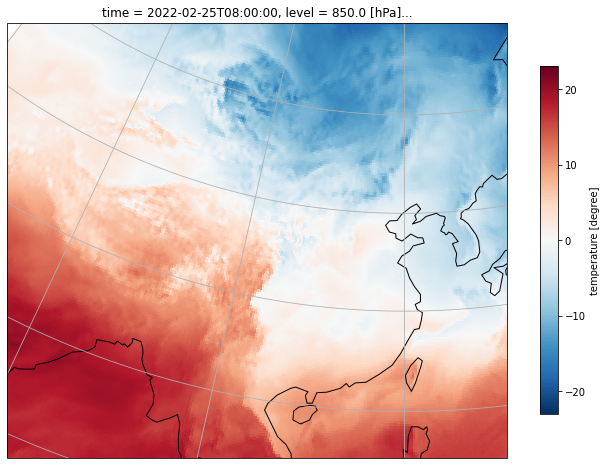

In [7]:
# 绘制图像
fig = plt.figure(figsize=(12,8))
ax = plt.axes(projection=ccrs.LambertConformal(central_longitude=120))
data.TEM.plot(ax=ax, transform=ccrs.PlateCarree(), cbar_kwargs={'shrink': 0.8})
ax.coastlines()
ax.gridlines()
ax.set_extent([80,130,15,54], crs=ccrs.PlateCarree())

## 2.2 读取多个时次的模式预报数据

In [8]:
%time
directory = "ECMWF_HR/TMP/500"
fhours = np.arange(0, 132, 12)
filenames = ['22022208.'+'%03d'%(fhour) for fhour in fhours]
data = get_model_grids(directory, filenames, varname='HGT', varattrs={'long_name':'geopotential height', 'units':'dagpm'}, cache=False)

Wall time: 0 ns


In [9]:
data

<xarray.Dataset>
Dimensions:                  (lat: 281, time: 11, level: 1, lon: 361)
Coordinates:
  * lat                      (lat) float64 -10.0 -9.75 -9.5 ... 59.5 59.75 60.0
  * time                     (time) datetime64[ns] 2022-02-22T08:00:00 ... 20...
  * level                    (level) float32 500.0
  * lon                      (lon) float64 60.0 60.25 60.5 ... 149.5 149.8 150.0
    forecast_reference_time  datetime64[ns] 2022-02-22T08:00:00
    forecast_period          (time) float64 0.0 12.0 24.0 ... 96.0 108.0 120.0
Data variables:
    HGT                      (time, level, lat, lon) float32 nan nan ... -35.82
Attributes:
    Conventions:  CF-1.6
    Origin:       MICAPS Cassandra DB

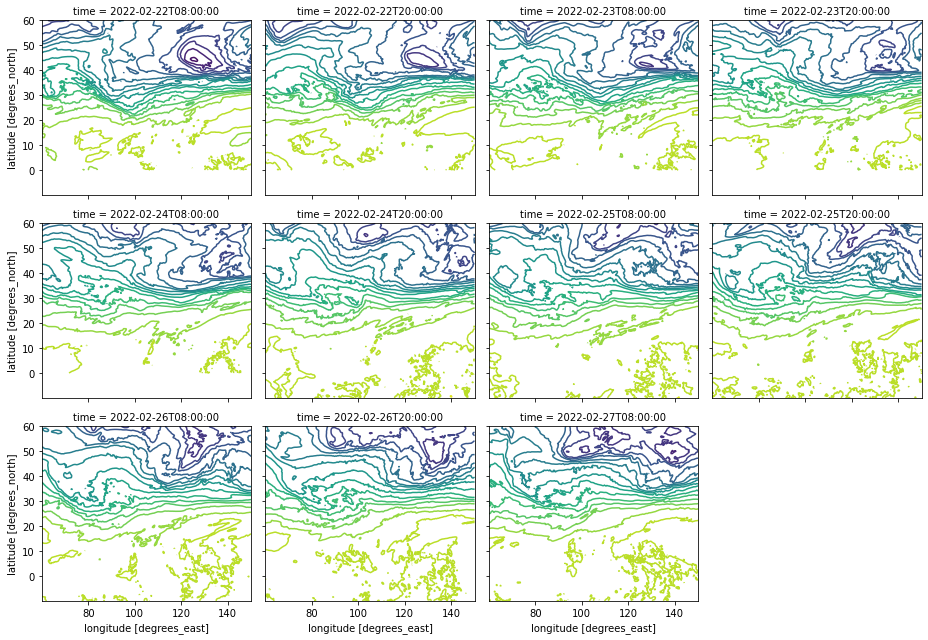

In [10]:
# 绘制图像
data.HGT.isel(level=0).plot.contour(col='time', col_wrap=4, levels=20)

## 2.3 读取集合预报数据

In [11]:
%time
directory = "ECMWF_ENSEMBLE/RAW/RAIN24"
filenames = get_file_list(directory)[:3]
data = get_model_grids(directory, filenames=filenames, varname='precipitation',
                      varattrs={'long_name':'accumulated precipitation', 'units':'mm'},
                      cache=False)
data

Wall time: 0 ns


<xarray.Dataset>
Dimensions:                  (number: 51, time: 3, lat: 121, lon: 261)
Coordinates:
  * number                   (number) int32 0 1 2 3 4 5 6 ... 45 46 47 48 49 50
  * time                     (time) datetime64[ns] 2022-03-06T08:00:00 ... 20...
  * lat                      (lat) float64 0.0 0.5 1.0 1.5 ... 59.0 59.5 60.0
  * lon                      (lon) float64 50.0 50.5 51.0 ... 179.0 179.5 180.0
    forecast_reference_time  datetime64[ns] 2022-02-23T08:00:00
    forecast_period          (time) float64 264.0 288.0 300.0
Data variables:
    precipitation            (number, time, lat, lon) float64 0.0 0.0 ... 1.228
Attributes:
    Conventions:  CF-1.6
    Origin:       MICAPS Cassandra DB

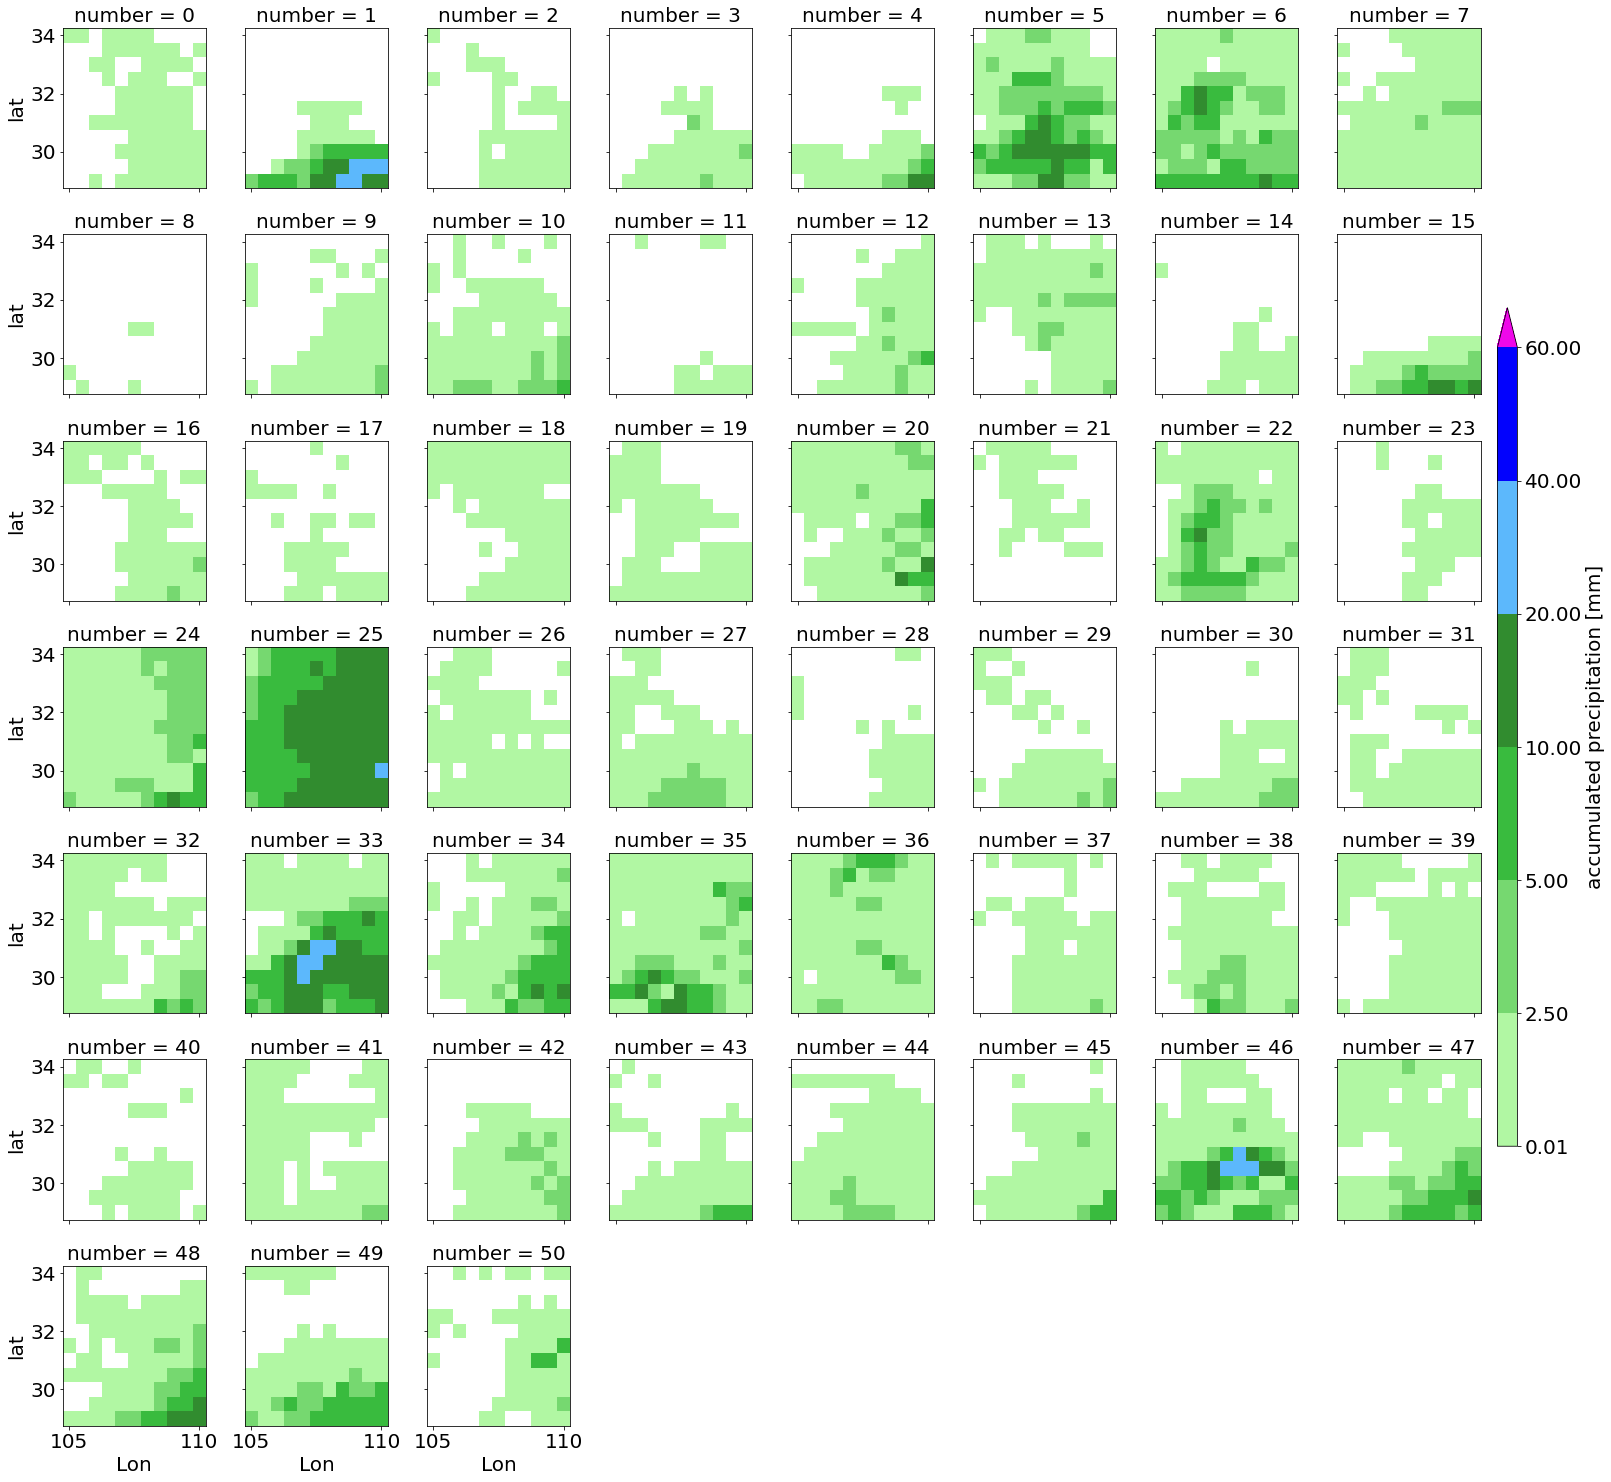

In [13]:
# set colors and levels
clevs = [0.01, 2.5, 5, 10, 20, 40, 60]
colors = ['#b1f7a3', '#76d870', '#39bb3e', '#318c2f', '#5cb8fc', '#0202fd', '#ef08e9']
cmap, norm = mpl.colors.from_levels_and_colors(clevs, colors, extend='max')

plt.rcParams['font.size'] = '20'
subdata = data.sel(lon=slice(105, 110), lat=slice(29, 34))
fg = subdata.precipitation.isel(time=0).plot(
    col='number', col_wrap=8, cmap=cmap, norm=norm, extend="max", \
    sharex=True, sharey=True,
    cbar_kwargs={"aspect":40, "shrink":0.6, "pad":0.01})
fg.set_xlabels("Lon")
fg.set_ylabels("lat")

## 2.4 读取卫星图像数据

In [14]:
# 获得风云4A中国区域4通道产品
directory = "SATELLITE/FY4A/L1/CHINA/C008"
data = get_fy_awx(directory)
data

<xarray.Dataset>
Dimensions:  (time: 1, channel: 1, lat: 1001, lon: 1751)
Coordinates:
  * time     (time) datetime64[ns] 2022-02-24T07:15:00
  * channel  (channel) int16 5
  * lat      (lat) float64 15.0 15.04 15.08 15.12 ... 54.88 54.92 54.96 55.0
  * lon      (lon) float64 70.0 70.04 70.08 70.12 ... 139.9 139.9 140.0 140.0
Data variables:
    image    (time, channel, lat, lon) float64 296.8 296.3 296.3 ... 258.7 260.6
Attributes:
    Conventions:  CF-1.6
    Origin:       MICAPS Cassandra DB

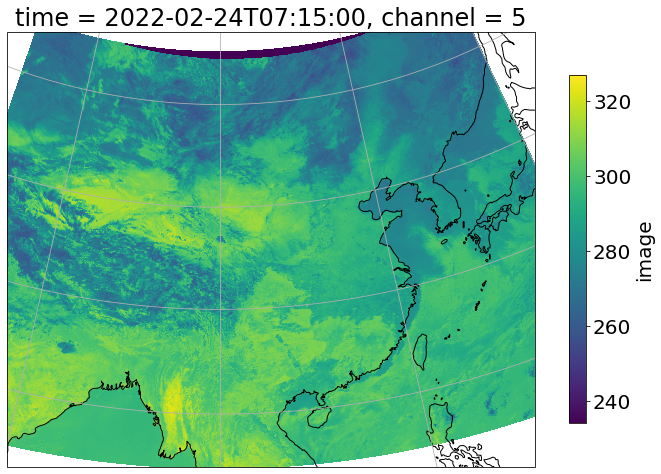

In [15]:
# 绘制图像
fig = plt.figure(figsize=(12,8))
ax = plt.axes(projection=ccrs.LambertConformal(central_longitude=100))
data.image[0,0,:,:].plot(ax=ax, transform=ccrs.PlateCarree(), cbar_kwargs={'shrink': 0.8})
ax.coastlines()
ax.gridlines()
ax.set_extent([80,130,15,54], crs=ccrs.PlateCarree())

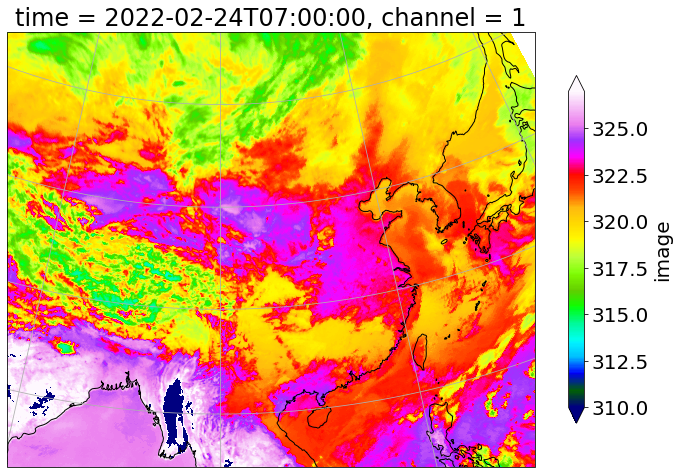

In [16]:
# 风云2静止卫星图像
directory = "SATELLITE/FY2/L1/IR1/EQUAL"
data = get_fy_awx(directory)

# 绘制图像
fig = plt.figure(figsize=(12,8))
ax = plt.axes(projection=ccrs.LambertConformal(central_longitude=100))
data.image[0,0,:,:].plot(ax=ax, transform=ccrs.PlateCarree(), cbar_kwargs={'shrink': 0.8}, cmap="gist_ncar", vmin=310, vmax=327)
ax.coastlines()
ax.gridlines()
ax.set_extent([80,130,15,54], crs=ccrs.PlateCarree())